In [ ]:
import networkx as nx
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
warnings.filterwarnings('ignore')
import random
from collections import Counter
import collections


import folium
from folium import plugins
from folium.plugins import MarkerCluster

import geopandas as gpd
from shapely.geometry import Point

import linkpred
from linkpred.evaluation import EvaluationSheet, StaticEvaluation
from linkpred.evaluation import Pair 
import itertools

from sklearn.metrics import roc_curve, auc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# Import the graph
G = nx.read_graphml("grafo_thr2.graphml")

In [ ]:
# Verify that every node has the attribute "etichetta"
tutti_hanno_label = all('etichetta' in G.nodes[nodo] for nodo in G.nodes())

if tutti_hanno_label:
    print("Tutti i nodi hanno un'etichetta.")
else:
    print("Alcuni nodi non hanno un'etichetta.")

Tutti i nodi hanno un'etichetta.


<h2>OPEN QUESTION</h2>

Mapping of the different types of entities: 
- 'ASSOCIAZIONI DI PROMOZIONE SOCIALE': 'APS',
- 'ORGANIZZAZIONI DI VOLONTARIATO': 'OV',
- 'IMPRESE SOCIALI': 'IS',
- 'ALTRI ENTI DEL TERZO SETTORE': 'AE',
- 'ENTI FILANTROPICI': 'EF',
- "SOCIETA' DI MUTUO SOCCORSO": 'SMS'

<h4>Label Analysis</h4>

In [ ]:
labels = nx.get_node_attributes(G,'etichetta') 

In [ ]:
num_unique_labels = len(set(labels.values()))
print(f"Numero di etichette diverse: {num_unique_labels}")

Numero di etichette diverse: 6


In [ ]:
label_counts = Counter(labels.values())

print("Numero di nodi per ogni etichetta:")
for label, count in label_counts.most_common():
    print(f"{label}: {count}")

Numero di nodi per ogni etichetta:
APS: 6506
OV: 5417
IS: 2636
AE: 2166
EF: 83
SMS: 20


In [ ]:
# Sort labels from the most to the least common
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

# Get labels and sorted counts
labels_sorted, counts_sorted = zip(*sorted_labels)

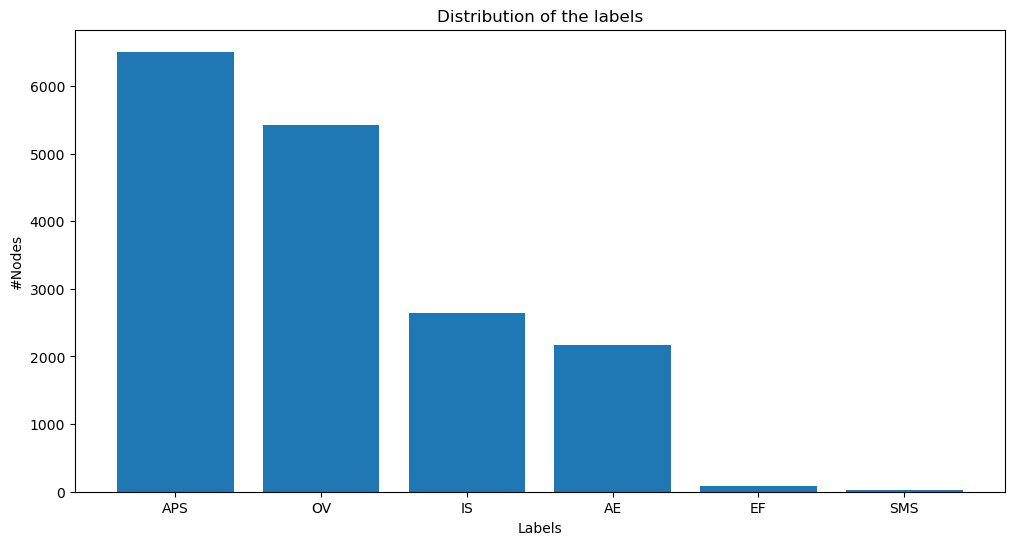

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(labels_sorted, counts_sorted)
plt.xlabel("Labels")
plt.ylabel("#Nodes")
plt.title("Distribution of the labels")
plt.show()

In [ ]:
df =pd.read_csv('df_finale_coordinate.csv')
df 

<h5>Visualizzazione con Folium map</h5>

In [ ]:
df.describe()

,Latitudine,Longitudine
count,16828.000000,16828.000000
mean,45.543896,9.487391
std,0.242051,0.539416
min,44.710903,8.532990
25%,45.443523,9.140450
50%,45.536066,9.280208
75%,45.689243,9.854661
max,46.544990,11.359760


In [ ]:
# Lat and Long for the center of the map from the describe()
mappa_lombardia = folium.Map(location=(45.543896, 9.487391), zoom_start=9) 

In [ ]:
marker_cluster = MarkerCluster().add_to(mappa_lombardia)

In [ ]:
# Add to the map the different entities, each with a different color icon 
# Definition of the label colors
colori_etichetta = {
    "APS": "red",
    "OV": "blue",
    "IS": "green",
    "AE": "purple",
    "EF": "orange",
    "SMS": "darkblue",
}

In [ ]:
# Loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, etichetta in zip(df.Latitudine, df.Longitudine, df.Denominazione, df.etichetta): # Name as the identifier for each point
    colore = colori_etichetta.get(etichetta, "gray")  # Default color if there is a point without the attribute

    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color=colore),
        popup=label,
    ).add_to(marker_cluster)

In [ ]:
#mappa_lombardia

<h5>OPEN QUESTION</h5>

In [ ]:
# Faccio diversi tentativi con diversi algoritmi di link prediction, per identificare qual è il migliore rispetto al 
# significato che hanno i miei link, quindi non considerando la distanza. 

# Successivamente andrò ad usare l'algoritmo più performante per cercare di rispondere alla mia domanda di ricerca. 

# Il significato dei miei link è che due enti sono connessi, si conoscono, se sono vicini geograficamente
# Voglio sfruttare queste conoscenze per mettere in contatto nuovi enti dello stesso tipo -> andrò poi ad usare link prediction e
# considerare solamente i link con nuovi nodi con la stessa etichetta 

We want to acquire knowledge about how the entities are connected (using different types of Link Prediction algorithm). </br>
Then, use this knowledge to predict new links between entities with the same label. </br>
The assumption is that if two nodes are already connected (so they are geographically near), they are more likely to know each other and they may encourage the collaboration between other organizations.

The analysis will be performed using the Giant Component, which has more than 11000 nodes, and it's connected, restricting the analysis.

<h5> Inital Link Prediction</h5>

Steps:
- Split the graph in train and test
- Try a few link prediction algorithms (Common Neighbors, Adamic-Adar, Katz)
- Evaluate the algorithms on the test 
- Use the best performing algorithm to predict new possible links between entities with the same label

In [ ]:
# Consider just the Giant Component as a subgraph
comp_0 = max(nx.connected_components(G), key=len)
G_comp_0 = G.subgraph(comp_0).copy()

In [ ]:
random.seed(42)  # Set a seed for reproducibility

# Divide edges between train and test in an 80/20 split
edges = list(G_comp_0.edges())
random.shuffle(edges)
train_size = int(len(edges) * 0.8)

train_edges = edges[:train_size]
test_edges = set(edges[train_size:])  # We use a set for a faster comparison

In [ ]:
# Create training subgraph
G_train = nx.Graph()
G_train.add_nodes_from(G_comp_0.nodes())  # Keep all nodes of the Giant Component
G_train.add_edges_from(train_edges)

COMMON NEIGHBOURS

In [ ]:
# Prediction with Common Neighbours - excluding existing edges
pred_cn = linkpred.predictors.CommonNeighbours(G_train, excluded=G_train.edges())

In [ ]:
result_cn = pred_cn.predict()

In [ ]:
top_cn = result_cn.top(5)
for edge, score in top_cn.items():
    print(edge, score)

PER MILANO - ENTE DEL TERZO SETTORE - FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE 618.0
U.A.I. RIFUGIO ANIMALI ABBANDONATI ODV - ASSOCIAZIONE PAOLO PINI ORGANIZZAZIONE DI VOLONTARIATO 613.0
FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE - EUROPEAN BREAST CANCER RESEARCH ASSOCIATION OF SURGICAL TRIALISTS (EU-BREAST) ETS 608.0
ON S.R.L. IMPRESA SOCIALE - AGESCI GRUPPO MILANO 45 APS 605.0
ASSOCIAZIONE PAOLO PINI ORGANIZZAZIONE DI VOLONTARIATO - AMICI DEL DIABETICO ODV 604.0


In [ ]:
predicted_cn = set(result_cn.keys())

In [ ]:
# Precision
precision = len(predicted_cn & test_edges) / len(predicted_cn)

# Recall
recall = len(predicted_cn & test_edges) / len(test_edges)

# F1-score
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0  # In order to avoid divisions by 0

# Print results
print(f"Precisione CN: {precision:.4f}")
print(f"Recall CN: {recall:.4f}")
print(f"F1-score CN: {f1_score:.4f}")


Precisione CN: 0.0817
Recall CN: 0.7707
F1-score CN: 0.1477


ADAMIC-ADAR

In [ ]:
# Prediction with Adamic-Adar - excluding existing edges
pred_aa = linkpred.predictors.AdamicAdar(G_train, excluded=G_train.edges()) 

In [ ]:
result_aa = pred_aa.predict()
# Execution time: approx 10 min

In [ ]:
top_aa = result_aa.top(5)
for edge, score in top_aa.items():
    print(edge, score)

PER MILANO - ENTE DEL TERZO SETTORE - FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE 96.78934717498946
U.A.I. RIFUGIO ANIMALI ABBANDONATI ODV - ASSOCIAZIONE PAOLO PINI ORGANIZZAZIONE DI VOLONTARIATO 96.37797191281786
FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE - EUROPEAN BREAST CANCER RESEARCH ASSOCIATION OF SURGICAL TRIALISTS (EU-BREAST) ETS 95.06179913663995
ON S.R.L. IMPRESA SOCIALE - AGESCI GRUPPO MILANO 45 APS 95.03572961448317
ASSOCIAZIONE PAOLO PINI ORGANIZZAZIONE DI VOLONTARIATO - AMICI DEL DIABETICO ODV 95.00801435264232


In [ ]:
predicted_aa = set(result_aa.keys())

In [ ]:
# Precision
precision_aa = len(predicted_aa & test_edges) / len(predicted_aa)

# Recall
recall_aa = len(predicted_aa & test_edges) / len(test_edges)

# F1-score
if precision_aa + recall_aa > 0:
    f1_score_aa = 2 * (precision_aa * recall_aa) / (precision_aa + recall_aa)
else:
    f1_score_aa = 0  # In order to avoid divisions by 0

# Print results
print(f"Precisione AA: {precision_aa:.4f}")
print(f"Recall AA: {recall_aa:.4f}")
print(f"F1-score AA: {f1_score_aa:.4f}")

Precisione AA: 0.0817
Recall AA: 0.7707
F1-score AA: 0.1477


KATZ

In [ ]:
# Prediction with Katz - excluding existing edges
pred_kz = linkpred.predictors.Katz(G_train, excluded=G_train.edges()) 

In [ ]:
result_kz = pred_kz.predict()
# Execution time: approx 5 min

Computing matrix powers: [############################################################] 5/5


In [ ]:
top_kz = result_kz.top(5)
for edge, score in top_kz.items():
    print(edge, score)

FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE - EUROPEAN BREAST CANCER RESEARCH ASSOCIATION OF SURGICAL TRIALISTS (EU-BREAST) ETS 0.0011358926172890002
PER MILANO - ENTE DEL TERZO SETTORE - FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE 0.0011341500054759999
U.A.I. RIFUGIO ANIMALI ABBANDONATI ODV - ASSOCIAZIONE PAOLO PINI ORGANIZZAZIONE DI VOLONTARIATO 0.001103054490733
FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE - FONDAZIONE MAZZOLA ETS 0.001100138432084
FONDAZIONE ROTARY CLUB MILANO PER MILANO - ENTE DEL TERZO SETTORE - BANCA E CULTURA ETS 0.0010999247261630001


In [ ]:
predicted_kz = set(result_kz.keys())

In [ ]:
# Precision
precision_kz = len(predicted_kz & test_edges) / len(predicted_kz)

# Recall
recall_kz = len(predicted_kz & test_edges) / len(test_edges)

# F1-score
if precision_kz + recall_kz > 0:
    f1_score_kz = 2 * (precision_kz * recall_kz) / (precision_kz + recall_kz)
else:
    f1_score_kz = 0  # In order to avoid divisions by 0

# Print results
print(f"Precisione KZ: {precision_kz:.4f}")
print(f"Recall KZ: {recall_kz:.4f}")
print(f"F1-score KZ: {f1_score_kz:.4f}")

Precisione KZ: 0.0233
Recall KZ: 0.7709
F1-score KZ: 0.0453


The best performing, both in terms of precision, recall, f1-score and in execution time is the algorithm that uses Common Neighbors. </br>
We use this algorithm to predict new links between orgs of the same type. We train on the whole giant component subgraph (since we want to predict new edges that don't exist yet)

In [ ]:
# Get the GC subgraph
comp_0 = max(nx.connected_components(G), key=len)
G_comp_0 = G.subgraph(comp_0).copy() 

In [ ]:
# Exclude existing edges (we want to predict new links)
pred_completo = linkpred.predictors.CommonNeighbours(G_comp_0, excluded=G_comp_0.edges())

In [ ]:
result_completo = pred_completo.predict()
# Execution time: approx 4 min

In [ ]:
print(len(result_completo))

1559283


In [ ]:
#Devo prendere gli edges tra enti dello stesso tipo
#Devo vedere che tipo di dato è result_completo -> dovrebbe essere un dizionario in cui le chiavi sono le coppie di enti 

In [ ]:
top_completo = result_completo.top(10)
for edge, score in top_completo.items():
    print(edge, score)

FRATELLI DI SAN FRANCESCO ODV - AMALO ARCENCIEL - ODV 473.0
VINCIAMO IL GIOCO - APS - SEGRETARIATO ATTIVITA' ECUMENICHE (S.A.E.) - APS 471.0
SEGRETARIATO ATTIVITA' ECUMENICHE (S.A.E.) - APS - NEED INSTITUTE, FOUNDATION FOR CURE AND REHABILITATION OF NEUROLOGICAL DISEASES ETS 471.0
SEGRETARIATO ATTIVITA' ECUMENICHE (S.A.E.) - APS - FONDAZIONE STUPENDE HAI LE MANI ENTE DEL TERZO SETTORE 471.0
SEGRETARIATO ATTIVITA' ECUMENICHE (S.A.E.) - APS - EQWA S.R.L. IMPRESA SOCIALE 471.0
SEGRETARIATO ATTIVITA' ECUMENICHE (S.A.E.) - APS - ASSOCIAZIONE ULPAN LINGUA E CULTURA EBRAICA APS 471.0
PRO TERRA SANCTA NETWORK APS - ASSOCIAZIONE LUMO - ENTE DEL TERZO SETTORE 471.0
FRATERNITA' DELLA STRADA APS - ASSOCIAZIONE LUMO - ENTE DEL TERZO SETTORE 471.0
ASSOCIAZIONE ORDINE FRANCESCANO - APS - ASSOCIAZIONE LUMO - ENTE DEL TERZO SETTORE 471.0
ASSOCIAZIONE LUMO - ENTE DEL TERZO SETTORE - ASSOCIAZIONE AMICI DEI BAMBINI E DELLE MAMME DI MAKOUA ETS 471.0


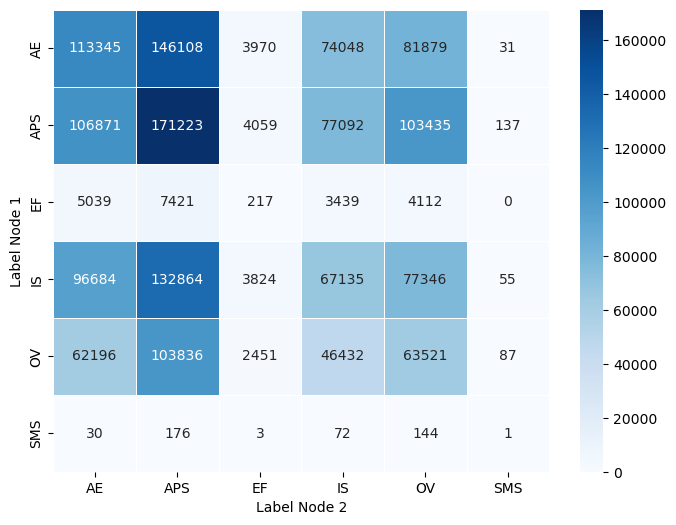

In [ ]:
# Costruisci una matrice con il numero di connessioni per ogni coppia di etichette
df_edges = pd.DataFrame([(labels[e[0]], labels[e[1]]) for e in result_completo.keys()], columns=['Etichetta_1', 'Etichetta_2'])
heatmap_data = df_edges.groupby(['Etichetta_1', 'Etichetta_2']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5)
plt.xlabel("Label Node 2")
plt.ylabel("Label Node 1")
plt.show()

In [ ]:
# Save all labels of the graph's nodes
labels = nx.get_node_attributes(G,'etichetta')

In [ ]:
# Checks if two nodes have the same label
same_type_pred = {
    edge: score
    for edge, score in result_completo.items()
    if labels[edge[0]] == labels[edge[1]]  # Controlla che i due nodi abbiano la stessa etichetta
}

In [ ]:
len(same_type_pred)
#415442

415442

In [ ]:
# Print edges labels to check
for edge, score in same_type_pred.items():
    print(labels[edge[0]])

In [ ]:
sorted_edges = sorted(same_type_pred.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# Print the top 50
print("Top 50 edges predetti tra nodi con la stessa etichetta:")
for edge, score in sorted_edges[:50]:
    print(f"Edge: {edge}, Score: {score:.4f}")

In [ ]:
# Print the last 50
print("Top 50 edges predetti tra nodi con la stessa etichetta:")
for edge, score in sorted_edges[50:]:
    print(f"Edge: {edge}, Score: {score:.4f}")

# The edges with score 1 have exactly 1 common neighbor

In [ ]:
# Get the score of ALL predicted links
scores = list(result_completo.values())  

# Score distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=50, kde=True) 
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Link Prediction scores distribution")
plt.grid(True)
plt.show()

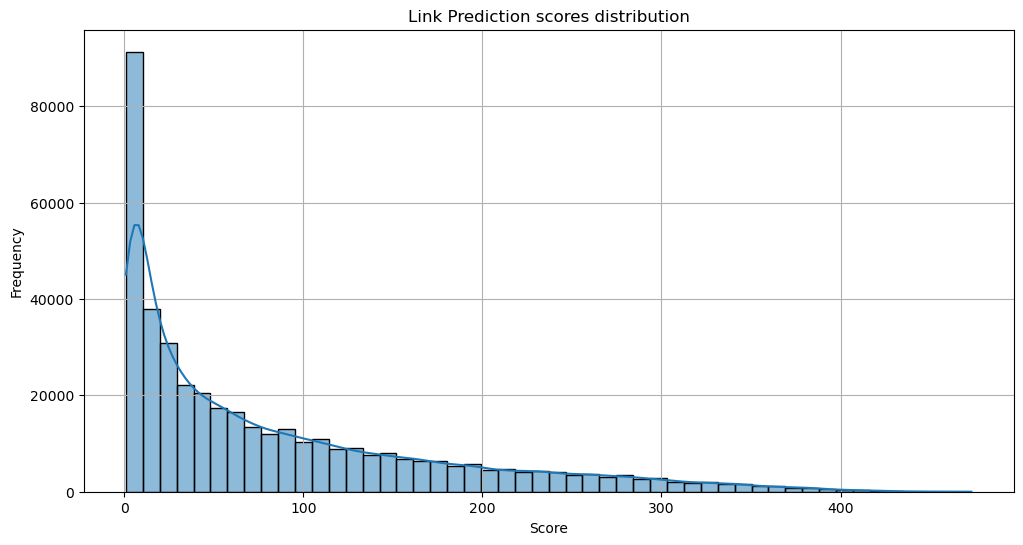

In [ ]:
# Get the score of JUST predicted links between nodes with the same label
scores = list(same_type_pred.values())  

# Score distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=50, kde=True)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Link Prediction scores distribution")
plt.grid(True)
plt.show()

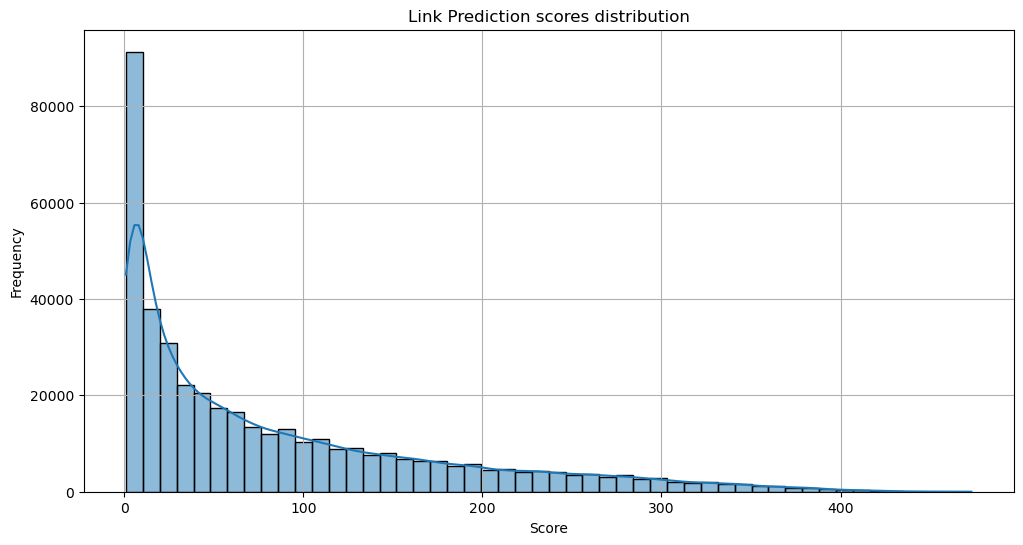

In [ ]:
# Get the score of JUST predicted links between nodes with the same label
scores = list(same_type_pred.values())  

# Score distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=50, kde=True)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Link Prediction scores distribution")
plt.grid(True)
plt.show()

In [ ]:
# Get score and labels
edges = list(same_type_pred.keys()) 
scores = list(same_type_pred.values())  # Score associated with the edges
# print(edges)

In [ ]:
labels_edges = []
for edge, score in same_type_pred.items():
    labels_edges.append(labels[edge[0]])

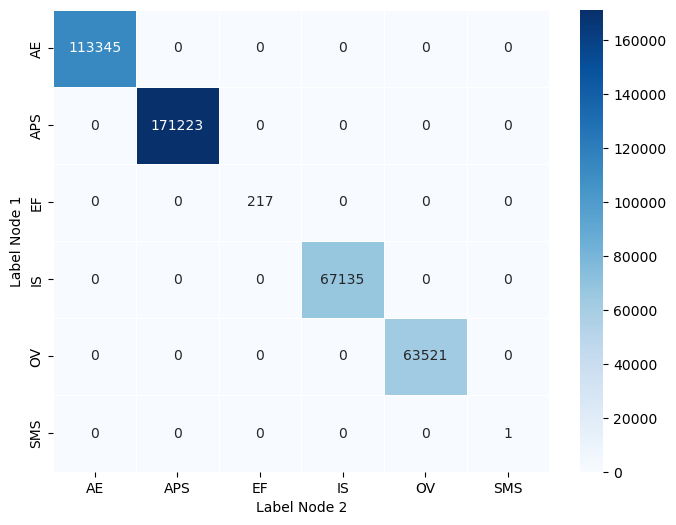

In [ ]:
# Build matrix with the number of connection for each pair of labels
df_edges = pd.DataFrame([(labels[e[0]], labels[e[1]]) for e in same_type_pred.keys()], columns=['Etichetta_1', 'Etichetta_2'])
heatmap_data = df_edges.groupby(['Etichetta_1', 'Etichetta_2']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5)
plt.xlabel("Label Node 2")
plt.ylabel("Label Node 1")
plt.show()

In [ ]:
# Count the number of predicted edges for each label
edge_counts_by_label = Counter(labels[n1] for n1, n2 in same_type_pred.keys())

# Print the result
for label, count in edge_counts_by_label.items():
    print(f"Etichetta: {label} -> Archi predetti: {count}")

Etichetta: IS -> Archi predetti: 67135
Etichetta: OV -> Archi predetti: 63521
Etichetta: APS -> Archi predetti: 171223
Etichetta: AE -> Archi predetti: 113345
Etichetta: EF -> Archi predetti: 217
Etichetta: SMS -> Archi predetti: 1


In [ ]:
# Order the labels based on the number of predicted links
sorted_labels = sorted(edge_counts_by_label.items(), key=lambda x: x[1], reverse=True)
labels_sorted, counts_sorted = zip(*sorted_labels)

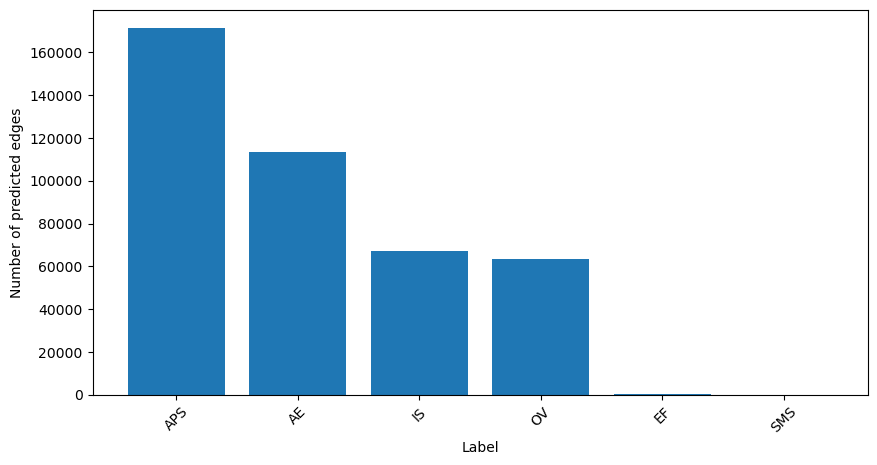

In [ ]:
# Plot the number of predicted links
plt.figure(figsize=(10, 5))
plt.bar(labels_sorted, counts_sorted)
plt.xlabel("Label")
plt.ylabel("Number of predicted edges")
plt.xticks(rotation=45)  # Rotate labels to facilitate readability
plt.show()

In [ ]:
# Count the number of edges with score different from 1
count_diff_from_1 = sum(1 for score in same_type_pred.values() if score != 1)
print("Numero di archi con score diverso da 1:", count_diff_from_1)


Numero di archi con score diverso da 1: 398513


In [ ]:
# Count the number of edges with score = 1
count_1 = sum(1 for score in same_type_pred.values() if score == 1)
print("Numero di archi con score uguale a 1:", count_1)

Numero di archi con score uguale a 1: 16929


In [ ]:
# Order the edges by decreasing score
sorted_edges = sorted(same_type_pred.items(), key=lambda x: x[1], reverse=True)

# Calculate the number of edges to consider (10%)
top_10_percent = int(len(sorted_edges) * 0.1)

# Select top 10% edges and save them in top_edges
top_edges = dict(sorted_edges[:top_10_percent])

print("Numero di archi selezionati:", len(top_edges))

Numero di archi selezionati: 41544


In [ ]:
# Count the number of predicted edges for each label
top_edge_counts_by_label = Counter(labels[n1] for n1, n2 in top_edges.keys())

# Print the result
for label, count in top_edge_counts_by_label.items():
    print(f"Etichetta: {label} -> Archi predetti: {count}")

Etichetta: OV -> Archi predetti: 3889
Etichetta: APS -> Archi predetti: 10428
Etichetta: AE -> Archi predetti: 20437
Etichetta: IS -> Archi predetti: 6734
Etichetta: EF -> Archi predetti: 56


In [ ]:
# Order the labels based on the number of predicted links
top_sorted_labels = sorted(top_edge_counts_by_label.items(), key=lambda x: x[1], reverse=True)
top_labels_sorted, top_counts_sorted = zip(*top_sorted_labels)

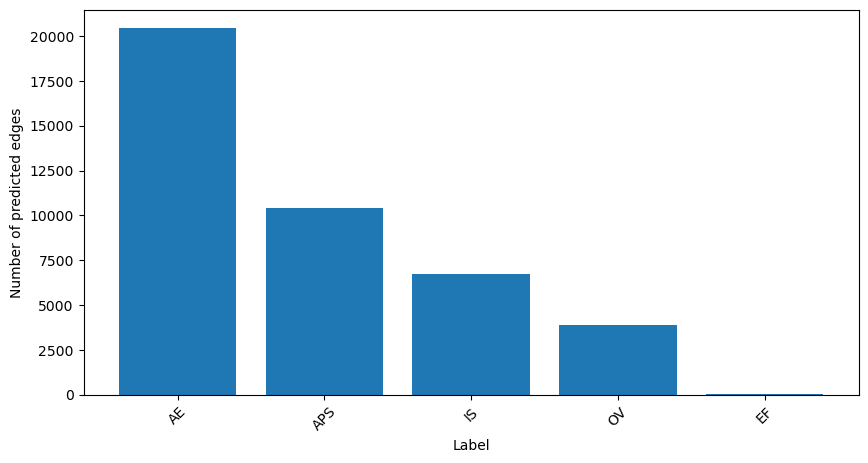

In [ ]:
# Plot the number of predicted links
plt.figure(figsize=(10, 5))
plt.bar(top_labels_sorted, top_counts_sorted)
plt.xlabel("Label")
plt.ylabel("Number of predicted edges")
plt.xticks(rotation=45)  # Rotate labels to facilitate readability
plt.show()